# MiniProject - Variant 3 - Group M

## Imports

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

import sklearn
from sklearn.preprocessing import StandardScaler
import time
import mat73 # requires pip install mat73

import pandas as pd
from align import align

from sklearn.decomposition import PCA, FastICA, NMF

from tqdm.notebook import tqdm

## Loading data

<span style="color:orange">**Warning: this will slow down really hard your computer**</span>

In [22]:
# !pip install gdown

In [26]:
# import gdown

# url = "https://drive.google.com/uc?id=1fhX5gCvmqkFrQ_Um9WXzYdmDUCXadzrJ"
# output = "sub/s1.mat"
# gdown.download(url, output, quiet = False)

# url = "https://drive.google.com/uc?id=1fhc-JCSnzE_oDOMszP9FsgmpxFUFAwYP"
# output = "sub/s2.mat"
# gdown.download(url, output, quiet = False)

# url = "https://drive.google.com/uc?id=1yWCwEKDaa97ZD44t1tS8i1IOJ5GIbROp"
# output = "sub/s3.mat"
# gdown.download(url, output, quiet = False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1fhX5gCvmqkFrQ_Um9WXzYdmDUCXadzrJ
From (redirected): https://drive.google.com/uc?id=1fhX5gCvmqkFrQ_Um9WXzYdmDUCXadzrJ&confirm=t&uuid=a4b47d53-0f99-4198-879d-b767b88db90e
To: c:\Users\APrap\Documents\MA3\NSSP\NSSP_421_Group_M\Project3\subj1_relevant_vars.mat
100%|██████████| 1.48G/1.48G [03:06<00:00, 7.90MB/s]


'subj1_relevant_vars.mat'

In [2]:
n_subject = 1

sub_files = []
emg = []
for i in range(1, n_subject+1):
    sub_files.append(loadmat('sub/s' + str(i) + '.mat'))
    print("The type of the file nb " + str(i) + " is: " + str(type(sub_files[i-1])))
    print("The keys of the file nb " + str(i) + " are: " + str(sub_files[i-1].keys()))
    print("\n\n")

The type of the file nb 1 is: <class 'dict'>
The keys of the file nb 1 are: dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new'])





Note for us: They say the signals were captured on 128 channels. From my understanding, its 64 channels on EMG_extensors, and 64 channels on EMG_flexors 

In [9]:
len(sub_files[0]['emg_flexors_new'].shape[1:])

2

In [25]:

print("number of uniques: " + str(len(np.unique(sub_files[0]["adjusted_class_new"]))))
print("number of uniques: " + str(len(np.unique(sub_files[0]["adjusted_repetition_new"]))))
print("number of uniques: " + str(sub_files[0]['emg_flexors_new'].shape))



number of uniques: 31
number of uniques: 6
number of uniques: (3000000, 8, 8)


2048

In [46]:
Fs = sub_files[0]['Fs'][0,0]
adjusted_class = sub_files[0]['adjusted_class_new']
adjusted_repetition = sub_files[0]['adjusted_repetition_new']
emg_flexors = sub_files[0]['emg_flexors_new']

## Part 1

### Preprocessing the data


In [47]:
# print(f'What are the shape of the data that we are working with? EMG_extensors: {emg_extensors.shape}, EMG_flexors {emg_flexors.shape}, adjusted_epetition {adjusted_repetition.shape}')

The movement should be the stimuli. We know there are 65 movements + 1 for the resting state, and the only keys to have 66 unique elements are `adjusted_class` and `class`, which correspondonds to the data description in https://www.nature.com/articles/s41597-021-00843-9

<span style="color:orange">check if adjusted_XXX are preprocessed for better correspondance to real movement or not</span>

<span style="color:orange">**WARNING: This will also slow down your computer**</span>

<span style="color:orange">**WARNING: I may be using incorrectly the number of channels**</span>

<span style="color:orange">**WARNING: Maybe we need to remove the outliers, thanks to the corresponding key**</span>

<span style="color:red">**ERROR: Laptop in fire 🔥**</span>


In [48]:
n_repetitions = len(np.unique(adjusted_repetition)) - 1 # -1 because 0 is not a repetition
n_stimuli = len(np.unique(adjusted_class)) - 1 # -1 because 0 is not a repetition
n_channels = emg_flexors.shape[1]*emg_flexors.shape[2]

emg_flexors = emg_flexors.reshape(emg_flexors.shape[0], n_channels)
print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 30
How many repetitions are there? 5


In [49]:
sos = butter(N=4, fs=Fs, Wn=(5,500), btype="bandpass", output="sos")
t = time.time()
emg_flexors_filtered = sosfiltfilt(sos, emg_flexors)
print("Elapsed time: ", time.time() - t)

Elapsed time:  13.319562196731567


In [50]:
from scipy.ndimage import convolve1d
# Easier method to compute the envelope 

emg_flexors_subsampled = emg_flexors_filtered[::2, :] # subsample by steps of 2 to reduce data size for easier computation
emg_flexors_rectified = emg_flexors_subsampled ** 2 # rectify the signal. We could also use abs

weights = np.ones(200)
t = time.time()
emg_flexors_envelope_200 = convolve1d(emg_flexors_rectified, weights=weights, axis=0)
print("Elapsed time: ", time.time() - t)



Elapsed time:  16.60477089881897


### Visualizing the data

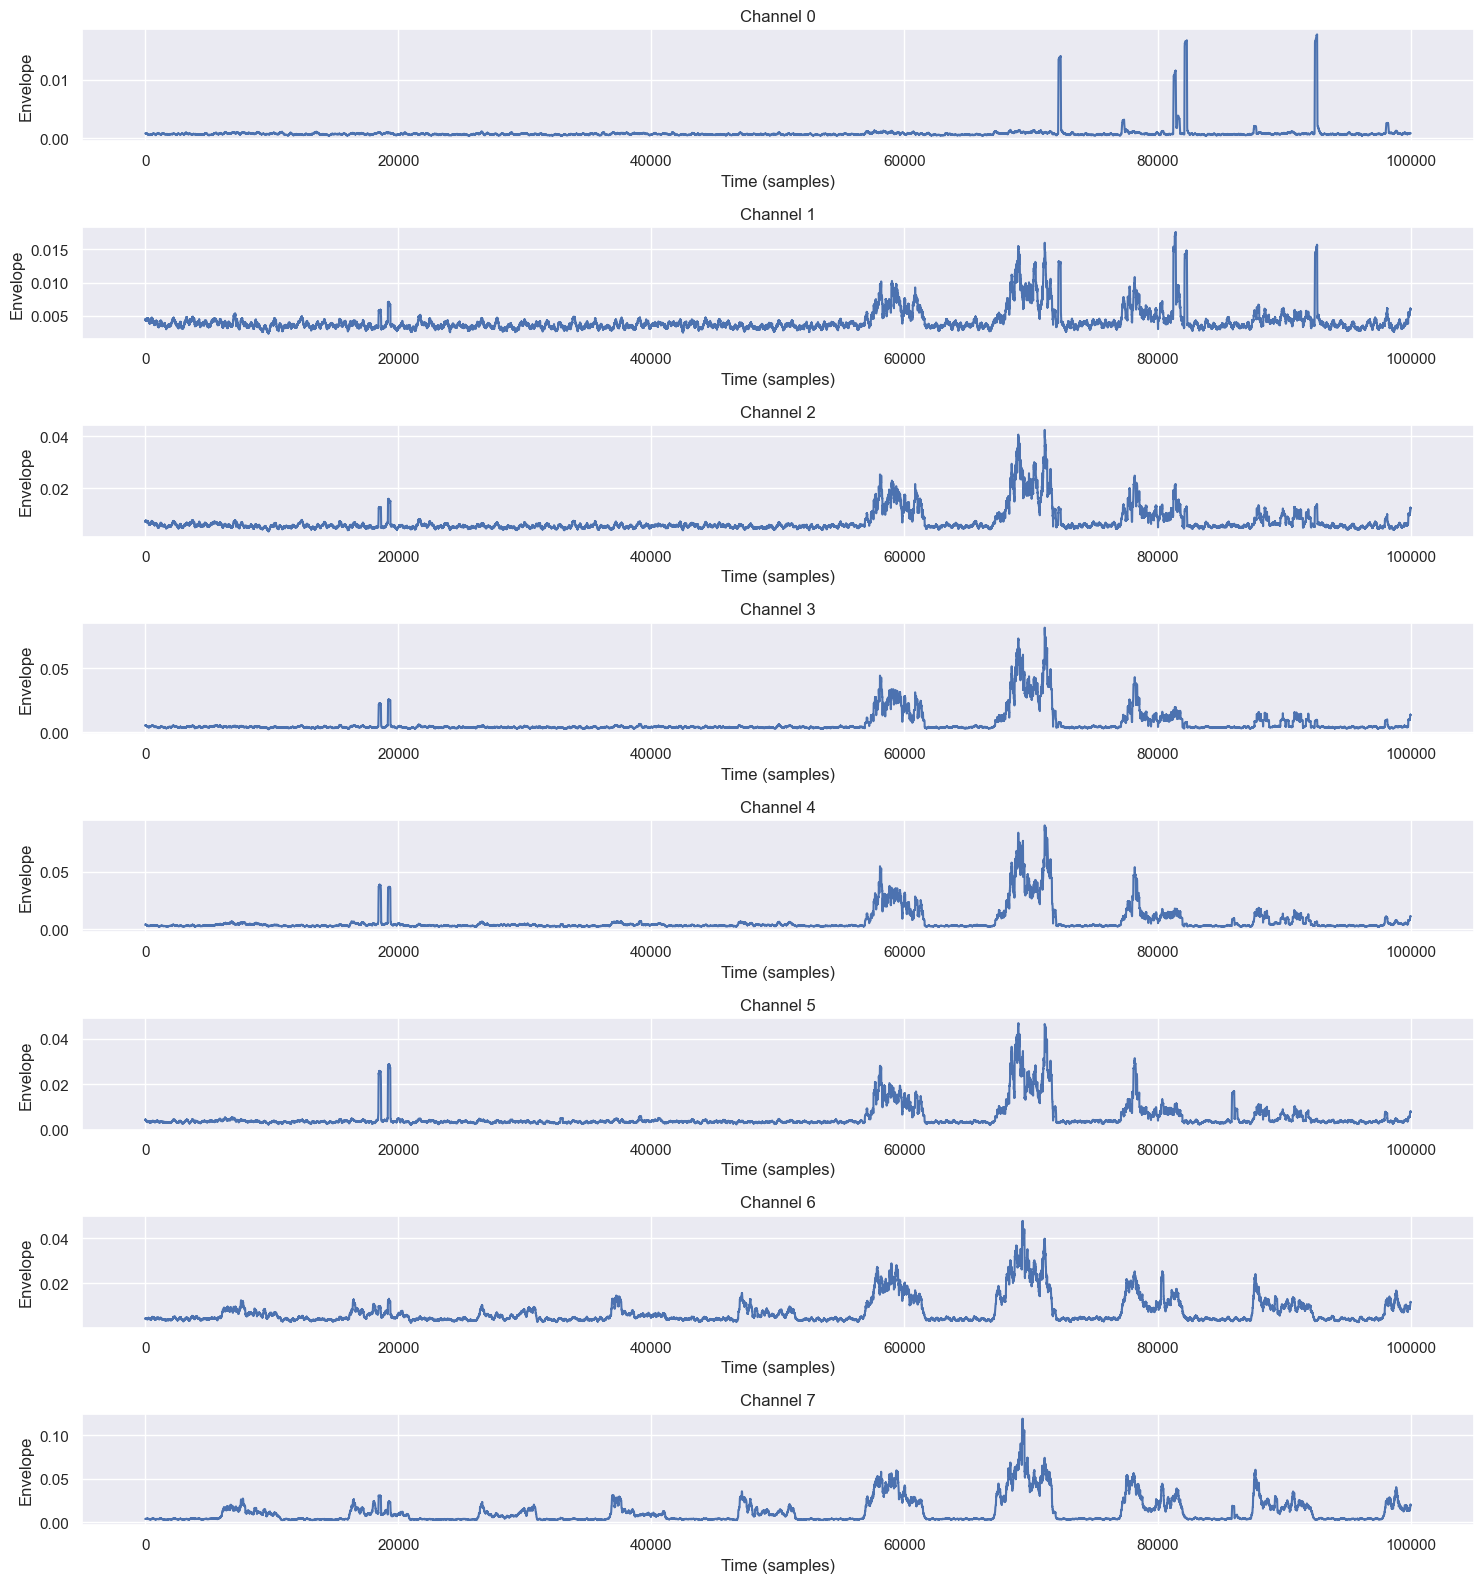

In [51]:
# #lets take a quick look at the data

# fig, ax = plt.subplots(8, 1, figsize=(15, 16))
# for i in range(8):
#     ax[i].plot(emg_flexors_envelope_200[:100000, i])
#     ax[i].set_title("Channel {}".format(i))
#     ax[i].set_xlabel("Time (samples)")
#     ax[i].set_ylabel("Envelope")

# plt.tight_layout()

## Part 2

*Compute the spatial synergies using different blind source separation algorithms
(e.g. PCA, ICA, NMF). Are the synergies stable?*

### Spatial synergies using BSS

### NMF

In [55]:
# For now let's just use 3 components. Parameters: init="nndsvda", max_iter=500.
nmf = NMF(n_components=3, init="nndsvda", max_iter=500)

t = time.time()
nmf.fit(emg_flexors_envelope_200)
print("Elapsed time: ", time.time() - t)

# Use nmf.fit_transform (W) and nmf.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
W_nmf = nmf.fit_transform(emg_flexors_envelope_200)
H_nmf = nmf.components_

Elapsed time:  25.29378890991211


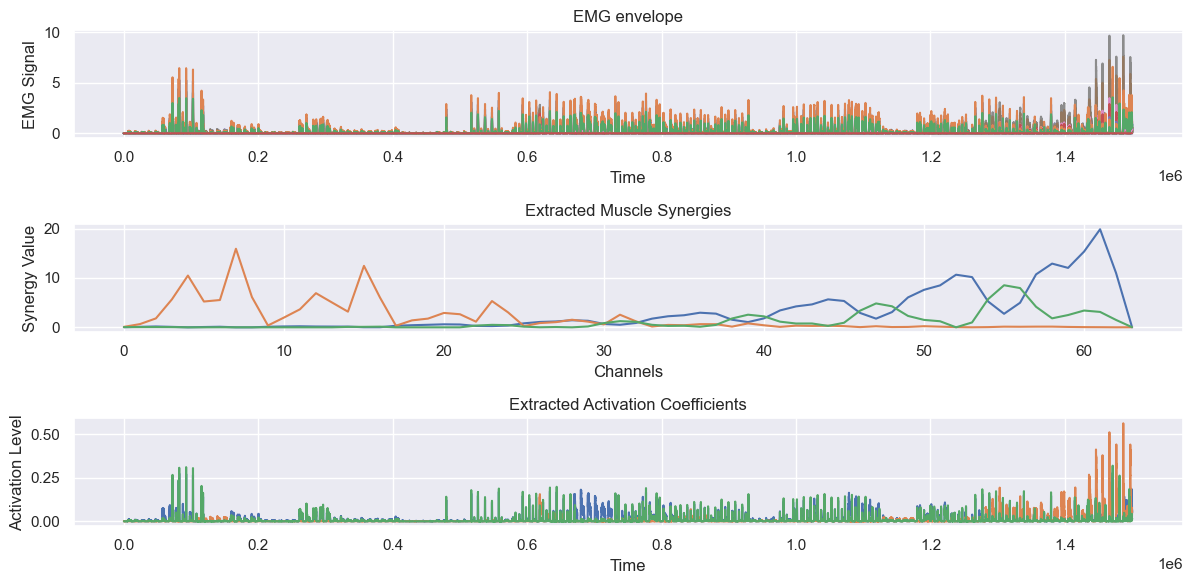

In [56]:
# Plot synthetic EMG data
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(emg_flexors_envelope_200)
plt.title('EMG envelope')
plt.xlabel('Time')
plt.ylabel('EMG Signal')

# Plot extracted synergies
plt.subplot(3, 1, 2)
plt.plot(H_nmf.T)
plt.title('Extracted Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

# Plot extracted activation coefficients
plt.subplot(3, 1, 3)
plt.plot(W_nmf)
plt.title('Extracted Activation Coefficients')
plt.xlabel('Time')
plt.ylabel('Activation Level')

plt.tight_layout()

### PCA

In [62]:
pca = PCA(n_components=3)

t = time.time()
pca.fit(emg_flexors_envelope_200)
print("Elapsed time: ", time.time() - t)

# Use pca.fit_transform (W) and pca.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
W_pca = pca.fit_transform(emg_flexors_envelope_200)
H_pca = pca.components_

Elapsed time:  10.865101099014282


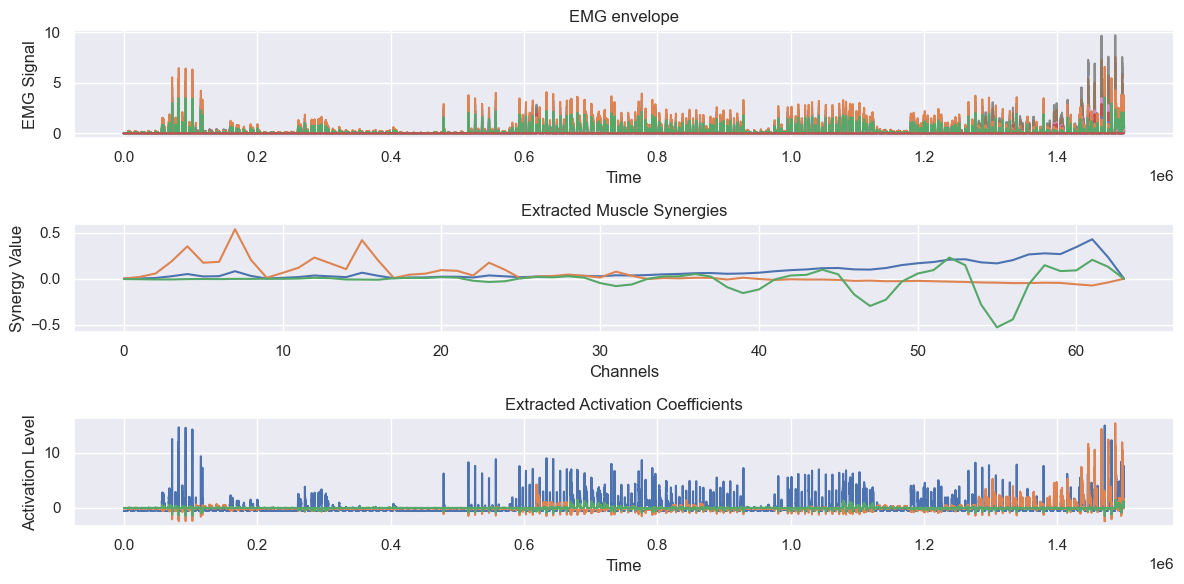

In [63]:
# Plot synthetic EMG data
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(emg_flexors_envelope_200)
plt.title('EMG envelope')
plt.xlabel('Time')
plt.ylabel('EMG Signal')

# Plot extracted synergies
plt.subplot(3, 1, 2)
plt.plot(H_pca.T)
plt.title('Extracted Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

# Plot extracted activation coefficients
plt.subplot(3, 1, 3)
plt.plot(W_pca)
plt.title('Extracted Activation Coefficients')
plt.xlabel('Time')
plt.ylabel('Activation Level')

plt.tight_layout()

### ICA

In [65]:
ica = FastICA(n_components=3)

t = time.time()
ica.fit(emg_flexors_envelope_200)
print("Elapsed time: ", time.time() - t)

# Use ica.transform (W) and ica.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
W_ica = ica.transform(emg_flexors_envelope_200)
H_ica = ica.components_

Elapsed time:  12.37224555015564


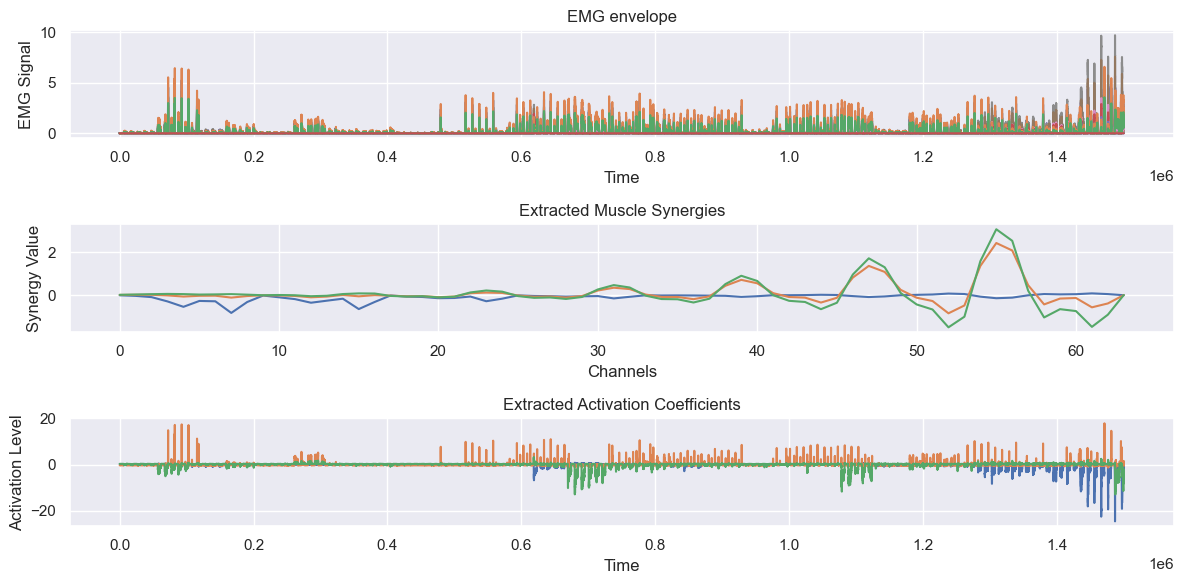

In [66]:
# Plot synthetic EMG data
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(emg_flexors_envelope_200)
plt.title('EMG envelope')
plt.xlabel('Time')
plt.ylabel('EMG Signal')

# Plot extracted synergies
plt.subplot(3, 1, 2)
plt.plot(H_ica.T)
plt.title('Extracted Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

# Plot extracted activation coefficients
plt.subplot(3, 1, 3)
plt.plot(W_ica)
plt.title('Extracted Activation Coefficients')
plt.xlabel('Time')
plt.ylabel('Activation Level')

plt.tight_layout()

## Part 3

*Compute the spatial synergies corresponding to different subsets of the data
samples. Are the synergies stable across the different subsets?*

### Comparaison



## Part 4

*Compute the spatial synergies for different subjects. Is it now stable across the
different subjects?*


## Part 5

*Try to vary the frequencies used in the preprocessing step. Compute the spatial
synergies again. Does the choice of filtering frequencies affects the stability of the
synergies?*

## Part 6

*Evaluate the stability of the synergies across the different BSS algorithms with
respect to the tasks 3-4-5. Which algorithm performs better, and which one is least
stable. Discuss the pros and cons of the different algorithms.
*
